# A Deep CNN-Based model for COVID-19 Detection from Chest Xray images (2 classes)

In this work, two classes of Covid-19 Radiography Database have been used to train the model. this data splited into three group: train, valid, and test1.

Also, Another local dataset has been added for second model testing (test2). This local dataset conains 341 Covid Xray images (include 111 Covid and 230 nonCovid) and collected from Iranian patients. further information will be provided.


This code is part of the new study and will be referenced to the article after the publication.
(M Amir Eshraghi, M Ghaderzadeh)

* © Proposed Method Implementation by M Amir Eshraghi. 
* Oct 2021 / Mashhad, Iran.

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import cv2

!pip install imutils
import os
from imutils import paths

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix

import shutil

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.applications.densenet import DenseNet201

import pandas as pd
import seaborn as sns
import itertools

In [2]:
print(tf.__version__)

2.4.1


In [3]:
#set seed number:
import random
random.seed(99)

**1- Data preparation**

Importing kaggle Data Train_Val_Test Set

Use /tmp to create temporary folder

In [4]:
path = "../input/covid19-radiography-database/COVID-19_Radiography_Dataset"

In [5]:
!ls /

bin   entrypoint.sh  kaggle  media  proc  run_jupyter.sh  srv  usr
boot  etc	     lib     mnt    root  sbin		  sys  var
dev   home	     lib64   opt    run   src		  tmp


In [6]:
!mkdir /tmp/COVID_Xray_data
!mkdir /tmp/COVID_Xray_data/train
!mkdir /tmp/COVID_Xray_data/train/Covid
!mkdir /tmp/COVID_Xray_data/train/nonCovid

In [8]:
org_Covid_path     =   "../input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID"
org_nonCovid_path  =   "../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal"

org_Covid_imgs     =   sorted(list(paths.list_images(org_Covid_path)))
org_nonCovid_imgs  =   sorted(list(paths.list_images(org_nonCovid_path)))

random.shuffle(org_Covid_imgs)
random.shuffle(org_nonCovid_imgs)

print('Number of Covid images----:',len(org_Covid_imgs))
print('Number of non-Covid images:',len(org_nonCovid_imgs))

Number of Covid images----: 3616
Number of non-Covid images: 10192


In [9]:
#balance the data and copy them into train directory

s=0
for img in org_Covid_imgs[:]:
    i = cv2.imread(img)
    i = cv2.cvtColor(i,cv2.COLOR_BGR2GRAY)
    i = cv2.resize(i,(300,300))
    i = np.repeat(i[..., np.newaxis], 3, -1)
    cv2.imwrite('/tmp/COVID_Xray_data/train/Covid/p'+str(s)+'.jpg',i)
    s+=1

random.shuffle(org_nonCovid_imgs)
for img in org_nonCovid_imgs[:7200]:
    i = cv2.imread(img)
    i = cv2.cvtColor(i,cv2.COLOR_BGR2GRAY)
    i = cv2.resize(i,(300,300))
    i = np.repeat(i[..., np.newaxis], 3, -1)
    cv2.imwrite('/tmp/COVID_Xray_data/train/nonCovid/n'+str(s)+'.jpg',i)
    s+=1

(300, 300, 3)

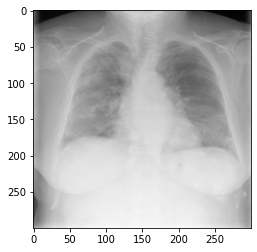

In [10]:
a= list(paths.list_images('/tmp/COVID_Xray_data/train/Covid'))
b=cv2.imread(a[4])
plt.imshow(b)
b.shape


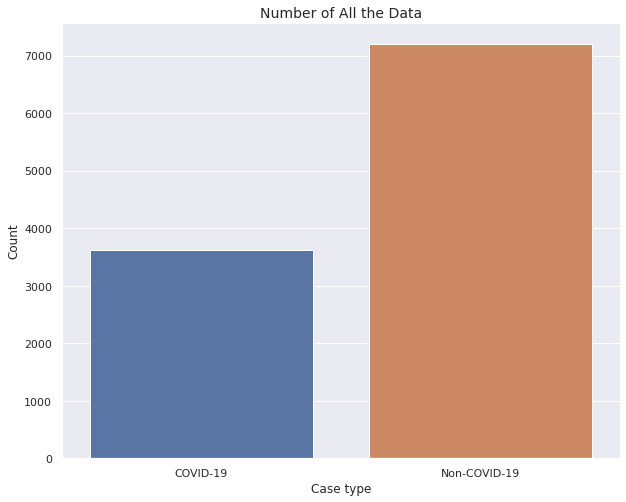

          Cases  Cases_count
0      COVID-19         3616
1  Non-COVID-19         7200


In [11]:
#print the number of all the data:

COUNT_COVID     = len(list(paths.list_images('/tmp/COVID_Xray_data/train/Covid')))
COUNT_Non_COVID = len(list(paths.list_images('/tmp/COVID_Xray_data/train/nonCovid')))

data = {'Cases':['COVID-19', 'Non-COVID-19'],
        'Cases_count':[COUNT_COVID, COUNT_Non_COVID]
       }

df = pd.DataFrame(data)

sns.set(style="darkgrid")
plt.figure(figsize=(10,8))
sns.barplot(x=df.index, y= df['Cases_count'].values)
plt.title('Number of All the Data', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(df.index)), ['COVID-19', 'Non-COVID-19'])
plt.show()

print(df)

In [12]:
#devided data into the Train, Valid and Test1 data set
data_dir = "/tmp/COVID_Xray_data/train/"
all_imgs = sorted(list(paths.list_images(data_dir)))
 
random.shuffle(all_imgs)

train_filenames, valid_filenames = train_test_split(all_imgs, test_size=0.18, shuffle=True)
test1_filenames, valid_filenames = train_test_split(valid_filenames, test_size=0.5, shuffle=True)

In [14]:
test2_path      =  '../input/covid19-xray-local-data'
test2_filenames =  sorted(list(paths.list_images(test2_path)))
random.shuffle(test2_filenames)

In [15]:
print("Number of Training images--:",len(train_filenames))
print("Number of Validation images:",len(valid_filenames))
print("Number of Test1 images-----:",len(test1_filenames))
print("Number of Test2 images-----:",len(test2_filenames))

b = test2_filenames[0]
print(b.split(os.path.sep)[4])

Number of Training images--: 8869
Number of Validation images: 974
Number of Test1 images-----: 973
Number of Test2 images-----: 341
Covid


In [16]:
#Create temporary folder for Valid images
!mkdir /tmp/COVID_Xray_data/valid
!mkdir /tmp/COVID_Xray_data/valid/Covid
!mkdir /tmp/COVID_Xray_data/valid/nonCovid

#Create temporary folder for TEST1 images
!mkdir /tmp/COVID_Xray_data/test1
!mkdir /tmp/COVID_Xray_data/test1/Covid
!mkdir /tmp/COVID_Xray_data/test1/nonCovid

#Create temporary folder for TEST2 images
!mkdir /tmp/COVID_Xray_data/test2
!mkdir /tmp/COVID_Xray_data/test2/Covid
!mkdir /tmp/COVID_Xray_data/test2/nonCovid

!ls '/tmp/COVID_Xray_data/train'

Covid  nonCovid


In [17]:
#Move the Valid data 
for x in valid_filenames:    
    if (x.split(os.path.sep)[4] == 'Covid'):
        shutil.move(x, "/tmp/COVID_Xray_data/valid/Covid")      
    if (x.split(os.path.sep)[4] == 'nonCovid'):
        shutil.move(x, "/tmp/COVID_Xray_data/valid/nonCovid")
            
#Move the Test1 data  
for x in test1_filenames:  
    if (x.split(os.path.sep)[4] == 'Covid'):
        shutil.move(x, "/tmp/COVID_Xray_data/test1/Covid")       
    if (x.split(os.path.sep)[4] == 'nonCovid'):
        shutil.move(x, "/tmp/COVID_Xray_data/test1/nonCovid")     

In [18]:
#Copy the Test2 data   
for x in test2_filenames:  
    if (x.split(os.path.sep)[4] == 'Covid'):
        shutil.copy(x, "/tmp/COVID_Xray_data/test2/Covid")       
    if (x.split(os.path.sep)[4] == 'nonCovid'):
        shutil.copy(x, "/tmp/COVID_Xray_data/test2/nonCovid")
        
a=list(paths.list_images("/tmp/COVID_Xray_data/test2"))

In [19]:
#check again the number of each group:
print("Number of Train images / all -----:",len(list(paths.list_images("/tmp/COVID_Xray_data/train"))))
print("Number of Train images / Covid ---:",len(list(paths.list_images("/tmp/COVID_Xray_data/train/Covid"))))
print("Number of Train images / non-Covid:",len(list(paths.list_images("/tmp/COVID_Xray_data/train/nonCovid"))))
print('-----------------------------------------')
print("Number of Valid images / all -----:",len(list(paths.list_images("/tmp/COVID_Xray_data/valid"))))
print("Number of Valid images / Covid ---:",len(list(paths.list_images("/tmp/COVID_Xray_data/valid/Covid"))))
print("Number of Valid images / non-Covid:",len(list(paths.list_images("/tmp/COVID_Xray_data/valid/nonCovid"))))
print('-----------------------------------------')
print("Number of Test1 images / all -----:",len(list(paths.list_images("/tmp/COVID_Xray_data/test1"))))
print("Number of Test1 images / Covid ---:",len(list(paths.list_images("/tmp/COVID_Xray_data/test1/Covid"))))
print("Number of Test1 images / non-Covid:",len(list(paths.list_images("/tmp/COVID_Xray_data/test1/nonCovid"))))
print('-----------------------------------------')
print("Number of Test2 images / all -----:",len(list(paths.list_images("/tmp/COVID_Xray_data/test2"))))
print("Number of Test2 images / Covid ---:",len(list(paths.list_images("/tmp/COVID_Xray_data/test2/Covid"))))
print("Number of Test2 images / non-Covid:",len(list(paths.list_images("/tmp/COVID_Xray_data/test2/nonCovid"))))


Number of Train images / all -----: 8869
Number of Train images / Covid ---: 2938
Number of Train images / non-Covid: 5931
-----------------------------------------
Number of Valid images / all -----: 974
Number of Valid images / Covid ---: 321
Number of Valid images / non-Covid: 653
-----------------------------------------
Number of Test1 images / all -----: 973
Number of Test1 images / Covid ---: 357
Number of Test1 images / non-Covid: 616
-----------------------------------------
Number of Test2 images / all -----: 341
Number of Test2 images / Covid ---: 111
Number of Test2 images / non-Covid: 230


**2 - Preproseccing and Augmentaion Pipeline**

In [20]:
#set the data locations
TRAIN_DATA_DIR= "/tmp/COVID_Xray_data/train"
VALID_DATA_DIR= "/tmp/COVID_Xray_data/valid"
TEST1_DATA_DIR= "/tmp/COVID_Xray_data/test1"
TEST2_DATA_DIR= "/tmp/COVID_Xray_data/test2"
TEST3_DATA_DIR= "/tmp/COVID_Xray_data/test3"

In [21]:
#defines:
IMG_HEIGHT, IMG_WIDTH= 224,224
BATCH_SIZE= 32
SEED= 99
EPOCHS= 40
initial_learning_rate = 0.0001 #for lr_schedule


Random images from dataset:


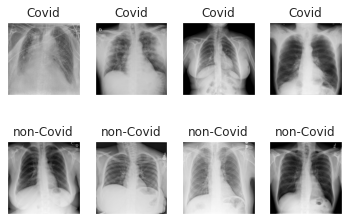

In [22]:
#create sample data and show them:

sample_imgs=[]
sample_labels=[]

tmp = sorted(list(paths.list_images('/tmp/COVID_Xray_data/train/Covid')))
random.shuffle(tmp)
for X in tmp[:4]:
    sample_imgs.append(cv2.imread(X))
    sample_labels.append('Covid')
        
tmp = sorted(list(paths.list_images('/tmp/COVID_Xray_data/train/nonCovid')))
random.shuffle(tmp)
for X in tmp[:4]:
    sample_imgs.append(cv2.imread(X))
    sample_labels.append('non-Covid')     

print('Random images from dataset:')
for i in range(0, 8):
    plt.subplot(2 , 4 , i+1)
    plt.imshow(sample_imgs[i+0])
    plt.title(sample_labels[i+0])
    plt.xticks([]),plt.yticks([])
    #show the plot
plt.show()  

#sample_imgs = np.asarray(sample_imgs)
#print(sample_imgs.shape)

In [23]:
#set the generator for Training dataset (Preprocessing and Augmentaion for Training set)
train_datagen = ImageDataGenerator(rescale=1./255,                    #rescaling into [0,1]
                                   vertical_flip=True,                #Augmentation
                                   horizontal_flip=True,              #Augmentation
                                   rotation_range=10                  #Augmentation,random rotations
)     
#train_datagen.fit(sample_imgs)
TRAIN_GENERATOR = train_datagen.flow_from_directory(
                                   TRAIN_DATA_DIR,
                                   target_size=(IMG_HEIGHT, IMG_WIDTH),
                                   batch_size=BATCH_SIZE,
                                   class_mode='binary',
                                   shuffle=True,
                                   seed=SEED)

Found 8869 images belonging to 2 classes.


Random images from Train set generator:
32


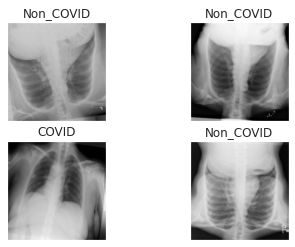

In [24]:
print('Random images from Train set generator:')
#Show random picture after the Augmentation:
for X_batch, y_batch in TRAIN_GENERATOR:
    print(len(y_batch))
    # create a grid of 3x3 images
    for i in range(0, 4):
        plt.subplot(2 , 2 , i+1)
        plt.imshow(X_batch[i])
        plt.title('COVID' if y_batch[i]==0 else 'Non_COVID')
        plt.xticks([]),plt.yticks([])
    # show the plot
    plt.show()
    break

In [25]:
#set Generators for Validation, Test1 and Test2:
datagen = ImageDataGenerator(rescale=1./255)    
                    
VALID_GENERATOR = datagen.flow_from_directory(
    VALID_DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=SEED)

TEST1_GENERATOR = datagen.flow_from_directory(
    TEST1_DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=SEED)

TEST2_GENERATOR = datagen.flow_from_directory(
    TEST2_DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=347,
    class_mode='binary',
    shuffle=True,
    seed=SEED)

Found 974 images belonging to 2 classes.
Found 973 images belonging to 2 classes.
Found 341 images belonging to 2 classes.


Random images from Test1 set generator:
32


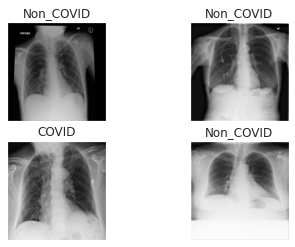

In [26]:
print('Random images from Test1 set generator:')
#Show random pictures from Test1 Generator:
for X_batch, y_batch in TEST1_GENERATOR:
    print(len(y_batch))
    # create a grid of 3x3 images
    for i in range(0, 4):
        plt.subplot(2 , 2 , i+1)
        plt.imshow(X_batch[i])
        plt.title('COVID' if y_batch[i]==0 else 'Non_COVID')
        plt.xticks([]),plt.yticks([])
    # show the plot
    plt.show()
    break

Random images from Test2 set generator:
341


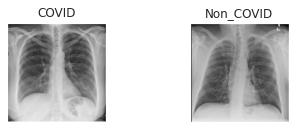

In [32]:
print('Random images from Test2 set generator:')
#Show random pictures from Test2 Generator:
for X_batch, y_batch in TEST2_GENERATOR:
    print(len(y_batch))
    # create a grid of 3x3 images
    for i in range(0, 2):
        plt.subplot(2 , 2 , i+1)
        plt.imshow(X_batch[i])
        plt.title('COVID' if y_batch[i]==0 else 'Non_COVID')
        plt.xticks([]),plt.yticks([])
    # show the plot
    plt.show()
    break

**3- Create the Model**

In [34]:
pretrained_base= DenseNet201(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_HEIGHT,IMG_WIDTH,3)
)

x = pretrained_base.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(256, activation='relu',kernel_initializer='he_uniform')(x)
x = tf.keras.layers.BatchNormalization()(x)
y = tf.keras.layers.Dropout(0.3)(x)

p = tf.keras.layers.Dense(2, activation='softmax')(y)

model = Model(inputs=pretrained_base.input, outputs=p)

#model.summery()

In [35]:
#Exponential decay for Learning rate:
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps = 40,
    decay_rate  = 0.96,
    staircase   = True)

#compile the model
model.compile(optimizer = Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
              loss      = 'sparse_categorical_crossentropy', 
              metrics   = ['accuracy'])

In [36]:
print("STEP_SIZE_TRAIN:",(TRAIN_GENERATOR.n//TRAIN_GENERATOR.batch_size))

STEP_SIZE_TRAIN: 277


**4- Training**

In [37]:
#to avoid overfitting
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=4)

# Training the model
trainer=model.fit(TRAIN_GENERATOR,
                  validation_data = VALID_GENERATOR,
                  epochs          = EPOCHS,
                  steps_per_epoch = 275,
                  verbose         = 2,
                  callbacks       = [early]
                  )

2021-10-28 06:07:13.185507: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-28 06:07:13.189604: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000160000 Hz


Epoch 1/40


2021-10-28 06:07:30.065022: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-28 06:07:30.916795: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-10-28 06:07:30.975915: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


275/275 - 156s - loss: 0.2505 - accuracy: 0.9065 - val_loss: 0.2449 - val_accuracy: 0.8943
Epoch 2/40
275/275 - 126s - loss: 0.0943 - accuracy: 0.9682 - val_loss: 0.4004 - val_accuracy: 0.9004
Epoch 3/40
275/275 - 127s - loss: 0.0755 - accuracy: 0.9746 - val_loss: 0.1260 - val_accuracy: 0.9517
Epoch 4/40
275/275 - 126s - loss: 0.0439 - accuracy: 0.9845 - val_loss: 0.2668 - val_accuracy: 0.9138
Epoch 5/40
275/275 - 127s - loss: 0.0342 - accuracy: 0.9885 - val_loss: 0.0556 - val_accuracy: 0.9877
Epoch 6/40
275/275 - 126s - loss: 0.0396 - accuracy: 0.9875 - val_loss: 0.2088 - val_accuracy: 0.9322
Epoch 7/40
275/275 - 126s - loss: 0.0269 - accuracy: 0.9917 - val_loss: 0.0519 - val_accuracy: 0.9836
Epoch 8/40
275/275 - 127s - loss: 0.0225 - accuracy: 0.9924 - val_loss: 0.0539 - val_accuracy: 0.9856
Epoch 9/40
275/275 - 126s - loss: 0.0198 - accuracy: 0.9934 - val_loss: 0.0556 - val_accuracy: 0.9877
Epoch 10/40
275/275 - 127s - loss: 0.0151 - accuracy: 0.9953 - val_loss: 0.0490 - val_accurac

**5- Evaluate and Results:**

In [38]:
print('Evaluate on test-data:')
model.evaluate(TEST1_GENERATOR)

Evaluate on test-data:
31/31 [==============================] - 4s 117ms/step - loss: 0.0284 - accuracy: 0.9908


[0.02842366136610508, 0.990750253200531]

In [39]:
print('Evaluate on test-data:')
model.evaluate(TEST2_GENERATOR)

Evaluate on test-data:
1/1 [==============================] - 6s 6s/step - loss: 0.0354 - accuracy: 0.9883


[0.0353914313018322, 0.9882698059082031]

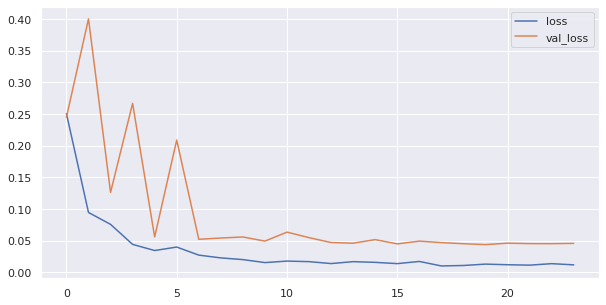

In [40]:
# Plotting train_loss vs val_loss
plt.figure(figsize=(10,5))
plt.plot(trainer.history["loss"],label="loss")
plt.plot(trainer.history["val_loss"],label="val_loss")
plt.legend()

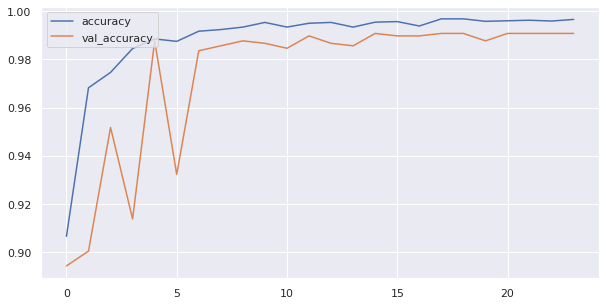

In [41]:
# Plotting train_accuracy vs Val_accuracy
plt.figure(figsize=(10,5))
plt.plot(trainer.history["accuracy"],label="accuracy")
plt.plot(trainer.history["val_accuracy"],label="val_accuracy")
plt.legend(loc='upper left')

In [46]:
#Plot the Confusion matrix:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    sns.set(style="dark")
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\n Accuracy={:0.4f}; Misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()



In [47]:
for X_batch, y_batch in TEST2_GENERATOR:
    y_test = y_batch
    X_test = X_batch
    break
    
pred = model.predict(X_test)
bin_predict = np.argmax(pred,axis=1)

#Confusion matrix:
matrix = confusion_matrix(y_test, bin_predict)
print('Confusion Matrix:\n',matrix)

Confusion Matrix:
 [[110   1]
 [  3 227]]


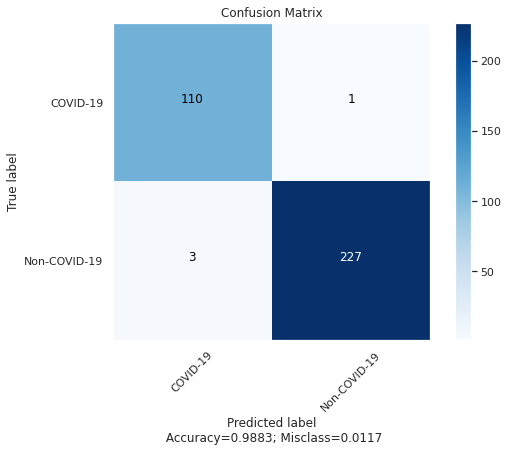

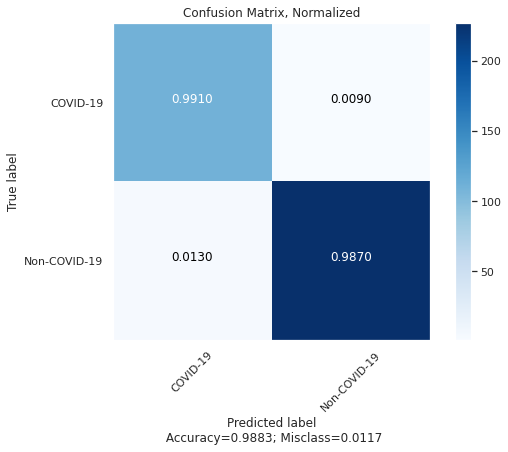

In [48]:
#confusion matrix for Test2:

plot_confusion_matrix(cm           = np.array(matrix), 
                      normalize    = False,
                      target_names = ['COVID-19','Non-COVID-19'],
                      title        = "Confusion Matrix")

plot_confusion_matrix(cm           = np.array(matrix), 
                      normalize    = True,
                      target_names = ['COVID-19','Non-COVID-19'],
                      title        = "Confusion Matrix, Normalized")

Shape of preds:  (341, 2)


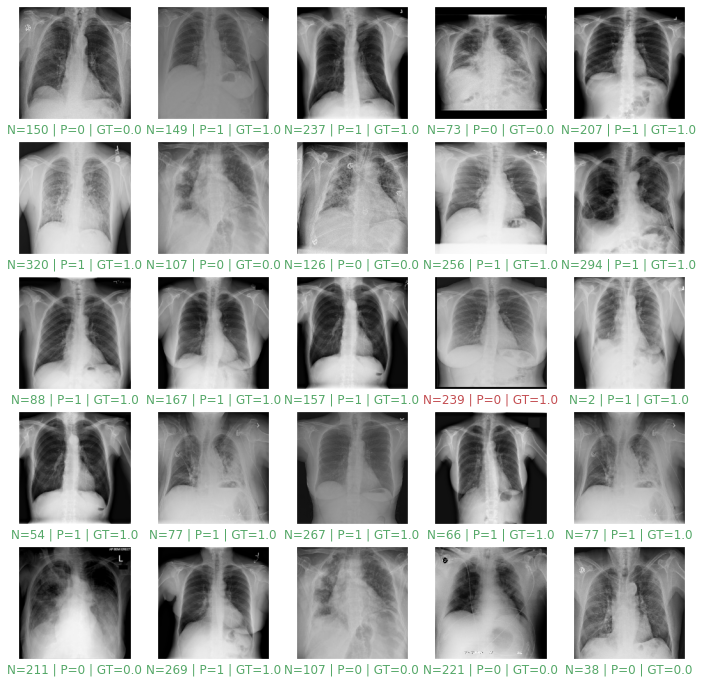

In [55]:
preds = model.predict(X_test)
#print(preds)
print('Shape of preds: ', preds.shape)
plt.figure(figsize = (12, 12))

number = np.random.choice(preds.shape[0])

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    number = np.random.choice(preds.shape[0])
    pred = np.argmax(preds[number])
    actual = (y_test[number])
    col = 'g'
    if pred != actual:
        col = 'r'
    plt.xlabel('N={} | P={} | GT={}'.format(number, pred, actual), color = col) #N= number P= prediction GT= actual (ground truth)
    plt.imshow(((X_test[number]* 255).astype(np.uint8)), cmap='binary')
plt.show()

In [56]:
FP = matrix.sum(axis=0) - np.diag(matrix)
FN = matrix.sum(axis=1) - np.diag(matrix)
TP = np.diag(matrix)
TN = matrix[:].sum() - (FP + FN + TP)

TPR = TP/(TP+FN)
TNR = TN/(TN+FP) 
PPV = TP/(TP+FP)
NPV = TN/(TN+FN)
FPR = FP/(FP+TN)
FNR = FN/(TP+FN)
FDR = FP/(TP+FP)

ACC = (TP+TN)/(TP+FP+FN+TN)

print('Other Metrics:')
MAE = mean_absolute_error(y_test, bin_predict)

print('MAE:', MAE)
print('Accuracy:', ACC)
print('Precision (positive predictive value):', PPV)
print('Recall (Sensitivity, hit rate, true positive rate):', TPR)
print('Specificity (true negative rate):', TNR)
print('Negative Predictive Value:', NPV)
print('Fall out (false positive rate):', FPR)
print('False Negative Rate:', FNR)
print('False discovery rate:', FDR)

Other Metrics:
MAE: 0.011730205278592375
Accuracy: [0.98826979 0.98826979]
Precision (positive predictive value): [0.97345133 0.99561404]
Recall (Sensitivity, hit rate, true positive rate): [0.99099099 0.98695652]
Specificity (true negative rate): [0.98695652 0.99099099]
Negative Predictive Value: [0.99561404 0.97345133]
Fall out (false positive rate): [0.01304348 0.00900901]
False Negative Rate: [0.00900901 0.01304348]
False discovery rate: [0.02654867 0.00438596]


In [42]:
# by M Amir Eshraghi